## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on MNIST data, a classification task.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!wget https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py
from utils import GradientRelativeEntropy

tf.random.set_seed(42)

--2024-08-19 02:46:19--  https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4677 (4.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.57K  --.-KB/s    in 0s      

2024-08-19 02:46:19 (44.4 MB/s) - ‘utils.py’ saved [4677/4677]



## The MNIST Data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28*28]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28*28]) / 255.0
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Train a Model with Gradient Loss

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(10)
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [10]:
optimizer = tf.optimizers.AdamW()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        gradient_loss = gradient_loss_fn(x, y)
        loss = tf.reduce_mean(gradient_loss.loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss

In [11]:
def evaluate(model):
    return accuracy_score(y_test, tf.argmax(model(x_test), axis=1))

In [12]:
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.one_hot(y_train, 10))
)
ds = ds.batch(128)

In [13]:
for epoch in range(50):
    for x, y in ds:
        loss = train_step(x, y)
    print(f'epoch: {epoch}, loss: {loss.numpy():.4f}, val_accuracy: {evaluate(model):.4f}')

epoch: 0, loss: 0.1723, val_accuracy: 0.9320
epoch: 1, loss: 0.1489, val_accuracy: 0.9511
epoch: 2, loss: 0.1386, val_accuracy: 0.9566
epoch: 3, loss: 0.1326, val_accuracy: 0.9593
epoch: 4, loss: 0.1296, val_accuracy: 0.9633
epoch: 5, loss: 0.1278, val_accuracy: 0.9656
epoch: 6, loss: 0.1260, val_accuracy: 0.9668
epoch: 7, loss: 0.1253, val_accuracy: 0.9702
epoch: 8, loss: 0.1213, val_accuracy: 0.9716
epoch: 9, loss: 0.1198, val_accuracy: 0.9722
epoch: 10, loss: 0.1181, val_accuracy: 0.9740
epoch: 11, loss: 0.1165, val_accuracy: 0.9748
epoch: 12, loss: 0.1163, val_accuracy: 0.9753
epoch: 13, loss: 0.1153, val_accuracy: 0.9765
epoch: 14, loss: 0.1149, val_accuracy: 0.9770
epoch: 15, loss: 0.1146, val_accuracy: 0.9774
epoch: 16, loss: 0.1136, val_accuracy: 0.9785
epoch: 17, loss: 0.1129, val_accuracy: 0.9790
epoch: 18, loss: 0.1113, val_accuracy: 0.9789
epoch: 19, loss: 0.1114, val_accuracy: 0.9788
epoch: 20, loss: 0.1107, val_accuracy: 0.9788
epoch: 21, loss: 0.1103, val_accuracy: 0.978

In [60]:
evaluate(model)

0.982

## Baseline Model with Usual Loss

For comparing, we use the same architecture for baseline model.

In [14]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(10),
])

In [18]:
baseline_model.compile(
    optimizer=tf.optimizers.AdamW(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [20]:
baseline_model.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_test, y_test),
    verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
)

Epoch 1/50
1875/1875 - 7s - 4ms/step - accuracy: 0.9742 - loss: 0.0858 - val_accuracy: 0.9735 - val_loss: 0.0874
Epoch 2/50
1875/1875 - 8s - 4ms/step - accuracy: 0.9824 - loss: 0.0549 - val_accuracy: 0.9786 - val_loss: 0.0728
Epoch 3/50
1875/1875 - 4s - 2ms/step - accuracy: 0.9876 - loss: 0.0385 - val_accuracy: 0.9790 - val_loss: 0.0739
Epoch 4/50
1875/1875 - 3s - 2ms/step - accuracy: 0.9900 - loss: 0.0312 - val_accuracy: 0.9763 - val_loss: 0.0917
Epoch 5/50
1875/1875 - 5s - 3ms/step - accuracy: 0.9906 - loss: 0.0277 - val_accuracy: 0.9808 - val_loss: 0.0771


In [59]:
evaluate(baseline_model)

0.9808

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [21]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.5, 50)):
    stddevs.append(stddev)
    # x_test_noised = x_test + tf.random.norm(tf.shape(x_test)) * stddev
    x_test_noised = x_test + tf.random.uniform(tf.shape(x_test), -1., 1.) * stddev
    x_test_noised = tf.clip_by_value(x_test_noised, 0., 1.)
    model_accs.append(
        accuracy_score(y_test, tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(y_test, tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|██████████| 50/50 [00:01<00:00, 25.82it/s]


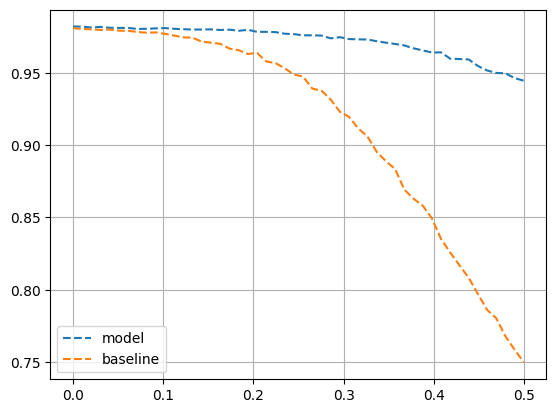

In [22]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## MNIST-C

In this section, we are to exame the model and the baseline model on the [MNIST-C](https://github.com/google-research/mnist-c) dataset, which was designed for evaluating the robustness of models trained on MNIST dataset.

We have downloaded the ZIP file from [here](https://zenodo.org/records/3239543), and unpacked into the current folder.

In [37]:
# # Or load MNIST-C dataset from drive.
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/mnist_c.zip -d ./

Mounted at /content/drive


In [45]:
# !unzip -x mnist_c.zip -d ./

In [57]:
print('noise type -- model accuracy -- baseline accuracy -- out perform')
for noise_type in os.listdir('mnist_c'):
    x_eval = np.load(f'mnist_c/{noise_type}/test_images.npy')
    y_eval = np.load(f'mnist_c/{noise_type}/test_labels.npy')

    x_eval = x_eval.astype('float32').reshape([-1, 28*28]) / 255.0
    y_eval = y_eval.astype('float32')

    model_eval = accuracy_score(y_eval, tf.argmax(model(x_eval), axis=1))
    baseline_eval = accuracy_score(y_eval, tf.argmax(baseline_model(x_eval), axis=1))
    out_perform = model_eval - baseline_eval

    print(f'{noise_type} -- {model_eval} -- {baseline_eval} -- {out_perform*100:.1f}%')

noise type -- model accuracy -- baseline accuracy -- out perform
shot_noise -- 0.9729 -- 0.9695 -- 0.3%
translate -- 0.3625 -- 0.3228 -- 4.0%
scale -- 0.8692 -- 0.7105 -- 15.9%
fog -- 0.2271 -- 0.2156 -- 1.1%
glass_blur -- 0.9462 -- 0.9236 -- 2.3%
dotted_line -- 0.9705 -- 0.9221 -- 4.8%
impulse_noise -- 0.9496 -- 0.8085 -- 14.1%
identity -- 0.982 -- 0.9808 -- 0.1%
spatter -- 0.9701 -- 0.9338 -- 3.6%
brightness -- 0.2287 -- 0.272 -- -4.3%
canny_edges -- 0.581 -- 0.6461 -- -6.5%
rotate -- 0.8702 -- 0.8532 -- 1.7%
zigzag -- 0.8991 -- 0.7243 -- 17.5%
shear -- 0.9453 -- 0.9397 -- 0.6%
motion_blur -- 0.8952 -- 0.7832 -- 11.2%
stripe -- 0.3737 -- 0.3085 -- 6.5%


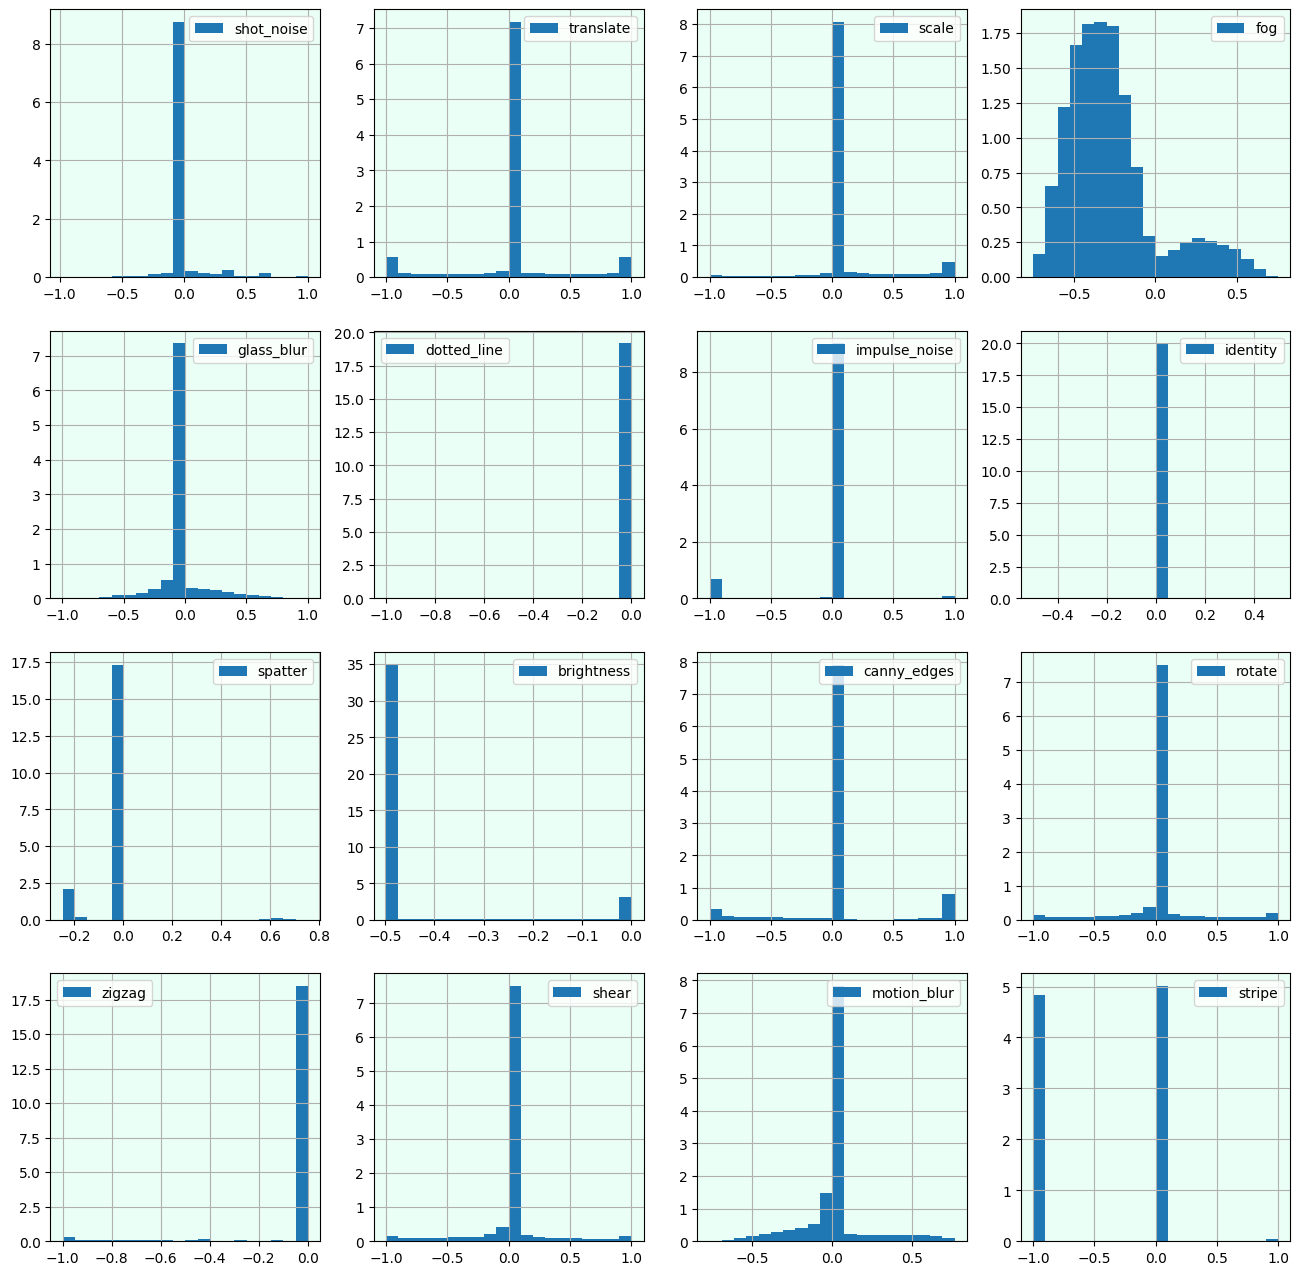

In [58]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, noise_type in enumerate(os.listdir('mnist_c')):
    j = i // 4
    k = i % 4
    ax = axs[j][k]

    x_eval = np.load(f'mnist_c/{noise_type}/test_images.npy')
    x_eval = x_eval.astype('float32').reshape([-1, 28*28]) / 255.0

    diff = (x_test - x_eval).reshape([-1])
    ax.hist(diff, 20, label=noise_type, density=True)
    ax.legend()
    ax.grid()
    ax.set_facecolor('#eafff5')

plt.show()

## Conclusion

- We have trained a simple feed-forward neural network on the MNIST dataset by minimizing the "gradient loss".
- While training the model by minimizing the "gradient loss", no validation or early stopping is employed. **Overfitting is absent naturally.**
- The performance examed by accuracy is the same as the baseline, which is trained by minimizing loss with validation and early stopping.
- **For Gaussian and uniform noise, the robustness is greatly out-performs the baseline.**
- We also examed more types of noise, using the MNIST-C dataset. We find that the robustness out-performs the baseline on most of the types of noise. Temporally, there is no hint about when robustness out-performs the baseline.